### 1. Введение

Для анализа мы будем использовать данные о гонкамх в классе машин Формула 1 за период с 1950 по 2017 годы.

Мы рассмотрим как развивалась данна серия гонок, динамику и структуру основных показателей, а также некоторые интересные факты

В ходе анализа мы попытаемся найти факторы которые влияют на успешность отдельных гонщиков и команд в данных гонках 

В ходе исследования мы рассмотрим следующие гипотезы:

• Нулевая гипотеза H₀: Средняя позиция гонщика на финише равна средней позиции команд(как правило их несколько за карьеру) в которых он был гонщиком

• Альтернативная гипотеза H₁: Средняя позиция гонщика на финише не равна средней позиции команд в которых он был гонщиком


In [1]:
#  импортируем необходимые библиотеки
import numpy as np
import pandas as pd
import openpyxl
import seaborn as sns
import matplotlib.pyplot as plt
import os
import pymysql
from IPython.display import Image
from IPython.core.display import HTML
from pandas_profiling import ProfileReport
from scipy import stats as st

In [2]:
# создоаем подключение к базе данных
host = os.getenv('MYSQL_HOST')
port = os.getenv('MYSQL_PORT')
user = os.getenv('MYSQL_USER')
password = os.getenv('MYSQL_PASSWORD')
database = os.getenv('MYSQL_DATABASE')

database = os.getenv('MYSQL_DATABASE')

conn = pymysql.connect(
    host=host,
    port=int(3306),
    user="root",
    passwd='',
    db="my_db",
    charset='utf8mb4')

Созданная мною база  данных в MySQL имеет следующюю схему:

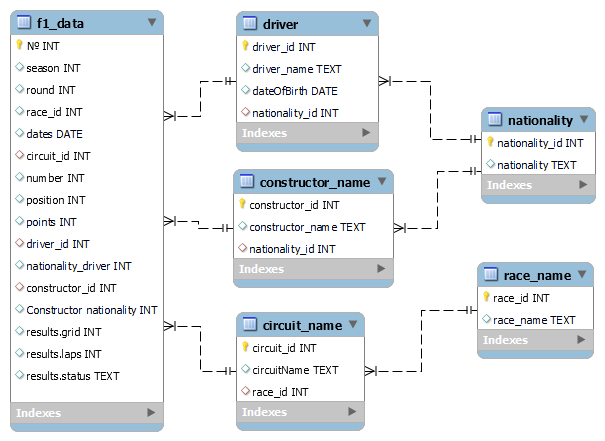

In [3]:
PATH = "data/scheme/"
Image(filename = PATH + "f1_db_scheme.png", width=600, height=600)

## Описание

•	season	-	год

•	round	-	номер гран при в сезоне

•	raceName	-	название гран при

•	dates	-	дата гонки

•	circuitName	-	название автодрома

•	number	-	номер гонщика

•	position	-	стартовая позиция

•	points	-	полученные очки

•	driver_name	-	имя гонщика

•	dateOfBirth	-	дата рождения

•	nationality	-	национальность

•	constructor_name	-	название производителя

•	results_grid	-	позиция на финише

•	results_laps	-	пройденные круги в гонке

•	results_status	-	результат

In [4]:
# загрузим основную таблицу
f1 = pd.read_sql_query("SELECT * FROM f1_data",
    conn)
f1.head()

,№,season,round,race_id,dates,circuit_id,number,position,points,driver_id,nationality_driver,constructor_id,Constructor_nationality,results_grid,results_laps,results_status
0,1,1950,1,9,1950-05-13,65,2,1,9,612,1,4,1,1,70,Finished
1,2,1950,1,9,1950-05-13,65,3,2,6,530,1,4,1,2,70,Finished
2,3,1950,1,9,1950-05-13,65,4,3,4,697,2,4,1,4,70,Finished
3,4,1950,1,9,1950-05-13,65,14,4,3,843,3,178,3,6,68,+2 Laps
4,5,1950,1,9,1950-05-13,65,15,5,2,524,3,178,3,9,68,+2 Laps


In [5]:
f1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23635 entries, 0 to 23634
Data columns (total 16 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   №                        23635 non-null  int64 
 1   season                   23635 non-null  int64 
 2   round                    23635 non-null  int64 
 3   race_id                  23635 non-null  int64 
 4   dates                    23635 non-null  object
 5   circuit_id               23635 non-null  int64 
 6   number                   23635 non-null  int64 
 7   position                 23635 non-null  int64 
 8   points                   23635 non-null  int64 
 9   driver_id                23635 non-null  int64 
 10  nationality_driver       23635 non-null  int64 
 11  constructor_id           23635 non-null  int64 
 12  Constructor_nationality  23635 non-null  int64 
 13  results_grid             23635 non-null  int64 
 14  results_laps             23635 non-nul

Проверка распределения null-значений с помощью тепловой карты.

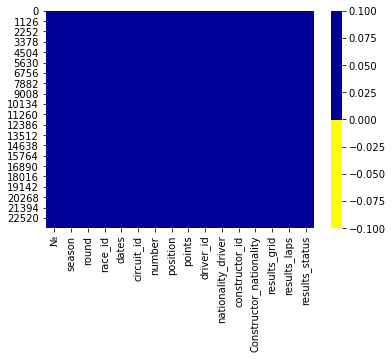

In [6]:
# желтый - пропущенные данные
colours = [ '#ffff00','#000099'] 
sns.heatmap(f1.isnull(), cmap=sns.color_palette(colours))
plt.show()

one_victory  - рассмотреть такто интересно сколько всего человек хоть раз победило

In [7]:
# !!!!!!!!!!!!!!!!!  ЗАГЛУШКА
# df = pd.read_sql_query('\
# ', conn)
# df.head()

In [8]:
# one_victory = pd.read_sql_query("\
# SELECT driver_name, dates FROM f1_data \
# JOIN driver ON driver.driver_id = f1_data.driver_id \
# JOIN circuit_name ON circuit_name.circuit_id = f1_data.circuit_id \
# JOIN race_name ON race_name.race_id = circuit_name.race_id \
# WHERE position = '1' AND driver_name IN (SELECT DISTINCT driver_name FROM driver) \
# ORDER BY dates", conn)
# one_victory.tail()

In [9]:
# посмотрим распределине количества гран при по годам и странам
race_years = pd.read_sql_query('''
SELECT distinct race_name, YEAR(dates) FROM f1_data 
JOIN circuit_name ON circuit_name.circuit_id = f1_data.circuit_id 
JOIN race_name ON race_name.race_id = circuit_name.race_id 
ORDER BY dates 
''', conn)
race_years.head()

,race_name,YEAR(dates)
0,British Grand Prix,1950
1,Monaco Grand Prix,1950
2,Indianapolis 500,1950
3,Swiss Grand Prix,1950
4,Belgian Grand Prix,1950


In [10]:
# посмотрим распределине гран при странам
race_years['race_name'] = race_years['race_name'].str[:-11]
race_years.groupby('race_name').count().sort_values('YEAR(dates)',ascending=False).head()

,YEAR(dates)
race_name,
Italian,68
Monaco,64
Belgian,61
French,58
European,57


In [11]:
# количество пилотов по годам
pilot = pd.read_sql_query('''
SELECT driver_name, YEAR(dates) FROM f1_data 
JOIN driver ON driver.driver_id = f1_data.driver_id 
ORDER BY dates
''', conn)
pilot

,driver_name,YEAR(dates)
0,Peter Walker,1950
1,Philippe Etancelin,1950
2,Prince Bira,1950
3,Reg Parnell,1950
4,Tony Rolt,1950
...,...,...
23630,Brendon Hartley,2017
23631,Carlos Sainz,2017
23632,Daniel Ricciardo,2017
23633,Esteban Ocon,2017


In [12]:
# все победы гонщиков 
win_driver = pd.read_sql_query('''
SELECT driver_name, COUNT(driver_name) AS wins 
FROM f1_data 
JOIN driver ON driver.driver_id = f1_data.driver_id 
WHERE position = 1 
GROUP BY driver_name 
ORDER BY COUNT(driver_name) DESC
''', conn)
win_driver.head()

,driver_name,wins
0,Michael Schumacher,90
1,Lewis Hamilton,62
2,Alain Prost,51
3,Sebastian Vettel,47
4,Ayrton Senna,40


In [13]:
# все старты с 1-го места(поул-позиция) гонщиков 
win_driver = pd.read_sql_query('''
SELECT driver_name, COUNT(driver_name) AS poles 
FROM f1_data 
JOIN driver ON driver.driver_id = f1_data.driver_id 
WHERE results_grid = 1 
GROUP BY driver_name 
ORDER BY COUNT(driver_name) DESC
''', conn)
win_driver.head()

,driver_name,poles
0,Lewis Hamilton,72
1,Michael Schumacher,68
2,Ayrton Senna,65
3,Sebastian Vettel,50
4,Jim Clark,33


In [14]:
#  количсество разных гонщиков и автопроизводителей по годам
distinct_drivers = pd.read_sql_query('''
SELECT YEAR(dates) as years, count(distinct driver_name) as pilot, count(distinct constructor_name) as constructor 
FROM f1_data 
JOIN driver ON driver.driver_id = f1_data.driver_id 
JOIN constructor_name  USING(constructor_id) 
GROUP BY years 
''', conn)
distinct_drivers.head()

,years,pilot,constructor
0,1950,81,24
1,1951,84,24
2,1952,105,25
3,1953,108,21
4,1954,97,19


In [15]:
# количество побед в одном сезоне, пилоты
win_pil_1seas = pd.read_sql_query('''
SELECT YEAR(dates), driver_name, COUNT(driver_name) AS wins 
FROM f1_data 
JOIN driver ON driver.driver_id = f1_data.driver_id 
WHERE position = 1 
GROUP BY YEAR(dates), driver_name 
ORDER BY COUNT(driver_name) DESC 
''', conn)
win_pil_1seas.head()

,YEAR(dates),driver_name,wins
0,2004,Michael Schumacher,13
1,2013,Sebastian Vettel,13
2,2002,Michael Schumacher,11
3,2011,Sebastian Vettel,11
4,2014,Lewis Hamilton,11


In [16]:
# количество поул-позиций в одном сезоне, пилоты
poles_pil_1seas = pd.read_sql_query('''
SELECT YEAR(dates), driver_name, COUNT(driver_name) AS poles 
FROM f1_data 
JOIN driver ON driver.driver_id = f1_data.driver_id 
WHERE results_grid = 1 
GROUP BY YEAR(dates), driver_name 
ORDER BY COUNT(driver_name) DESC 
''', conn)
poles_pil_1seas.head()

,YEAR(dates),driver_name,poles
0,2011,Sebastian Vettel,15
1,1988,Ayrton Senna,13
2,1989,Ayrton Senna,13
3,1993,Alain Prost,13
4,2016,Lewis Hamilton,12


In [17]:
# победа с самого долекого места на старте
win_far = pd.read_sql_query('''
SELECT driver_name, race_name.race_name, results_grid 
FROM f1_data 
JOIN driver ON driver.driver_id = f1_data.driver_id 
JOIN circuit_name USING(circuit_id) 
JOIN race_name ON race_name.race_id = circuit_name.race_id 
WHERE position = 1 
ORDER BY results_grid DESC 
''', conn)
win_far.head()

,driver_name,race_name,results_grid
0,John Watson,United States Grand Prix West,22
1,Bill Vukovich,Indianapolis 500,19
2,Rubens Barrichello,German Grand Prix,18
3,John Watson,Detroit Grand Prix,17
4,Kimi Raikkonen,Japanese Grand Prix,17


In [18]:
# самые молодые победители гран при
#  !!!!!!!!!!!!! гистограмма !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
age = pd.read_sql_query('''
SELECT  driver_name, race_name,  datediff(dates, dateOfBirth) / 365.25 as ages, YEAR(dates) 
FROM f1_data 
JOIN driver ON driver.driver_id = f1_data.driver_id 
JOIN circuit_name USING(circuit_id) 
JOIN race_name ON race_name.race_id = circuit_name.race_id 
WHERE position = 1 
ORDER BY ages 
''', conn)
age.head()

,driver_name,race_name,ages,YEAR(dates)
0,Max Verstappen,Spanish Grand Prix,18.6229,2016
1,Max Verstappen,Malaysian Grand Prix,20.0027,2017
2,Max Verstappen,Mexican Grand Prix,20.0794,2017
3,Sebastian Vettel,Italian Grand Prix,21.2019,2008
4,Sebastian Vettel,Chinese Grand Prix,21.7960,2009


In [19]:
# Гонщики, побеждавщие на автомобилях различных производителей
diff_constr = pd.read_sql_query('''
SELECT driver_name, count(distinct constructor_name) as constructor 
FROM f1_data 
JOIN driver ON driver.driver_id = f1_data.driver_id 
JOIN constructor_name  USING(constructor_id) 
WHERE position = 1 
GROUP BY driver_name 
ORDER BY constructor DESC 
''', conn)
diff_constr.head()


,driver_name,constructor
0,Stirling Moss,5
1,Alain Prost,4
2,Jackie Stewart,4
3,Juan Fangio,4
4,Carlos Reutemann,3


In [20]:
# constructor_poles
constructor_poles = pd.read_sql_query('''
SELECT constructor_name, COUNT(constructor_name) AS poles 
FROM f1_data 
JOIN constructor_name USING(constructor_id) 
WHERE results_grid = 1 
GROUP BY constructor_name 
ORDER BY COUNT(constructor_name) DESC 
''', conn)
constructor_poles.head()

,constructor_name,poles
0,Ferrari,218
1,McLaren,155
2,Williams,123
3,Lotus,89
4,Mercedes,88


In [21]:
# constructor_wins
constructor_wins = pd.read_sql_query('''
SELECT constructor_name, COUNT(constructor_name) AS wins 
FROM f1_data 
JOIN constructor_name USING(constructor_id) 
WHERE position = 1 
GROUP BY constructor_name 
ORDER BY COUNT(constructor_name) DESC 
''', conn)
constructor_wins.head()

,constructor_name,wins
0,Ferrari,230
1,McLaren,176
2,Williams,112
3,Mercedes,76
4,Lotus,69


In [22]:
# количество побед в одном сезоне, команды
df = pd.read_sql_query('''
SELECT YEAR(dates),  constructor_name, COUNT(constructor_name) AS wins_constr 
FROM f1_data 
JOIN constructor_name USING(constructor_id) 
WHERE position = 1 
GROUP BY YEAR(dates),  constructor_name 
ORDER BY COUNT(constructor_name) DESC 
''', conn)
df.head()

,YEAR(dates),constructor_name,wins_constr
0,2016,Mercedes,19
1,2014,Mercedes,16
2,2015,Mercedes,16
3,1988,McLaren,15
4,2002,Ferrari,15


In [23]:
# количество поулов в одном сезоне, команды
df = pd.read_sql_query('''
SELECT YEAR(dates),  constructor_name, COUNT(constructor_name) AS wins_constr 
FROM f1_data 
JOIN constructor_name USING(constructor_id) 
WHERE results_grid = 1 
GROUP BY YEAR(dates),  constructor_name 
ORDER BY COUNT(constructor_name) DESC 
''', conn)
df.head()

,YEAR(dates),constructor_name,wins_constr
0,2016,Mercedes,20
1,2011,Red Bull,18
2,2014,Mercedes,18
3,2015,Mercedes,18
4,1988,McLaren,15


In [24]:
# страны гонщиков
nat_driv = pd.read_sql_query('''
SELECT nationality, COUNT(distinct driver_name) AS Count 
FROM f1_data 
JOIN driver ON driver.driver_id = f1_data.driver_id 
JOIN nationality ON nationality.nationality_id = f1_data.nationality_driver 
GROUP BY nationality 
ORDER BY Count DESC 
''', conn)
nat_driv .head()

,nationality,Count
0,British,162
1,American,157
2,Italian,99
3,French,73
4,German,50


## анализ основной цели исследования
для этого необходимо сравнить результаты на финише гонщика в данной команде и медианного значения по данной команде за весь период

In [31]:
# выберем самых успешных гонщиков, выступавших в различные периоды времени
champions19 = pd.read_sql_query('''
SELECT driver_name, constructor_name, position 
FROM f1_data 
JOIN driver ON driver.driver_id = f1_data.driver_id 
JOIN constructor_name  USING(constructor_id) 
WHERE driver_name IN ('Ayrton Senna', 'Michael Schumacher', 'Alain Prost', 'Nelson Piquet','Nigel Mansell', 'Juan Fangio', 'Fernando Alonso','Lewis Hamilton', 'Jackie Stewart', 'Sebastian Vettel')  
''', conn)
# переименуем колонку для удобства
champions19.rename(columns={'position': 'driver_position'}, inplace=True)

# выберем все команды
consruct19 = pd.read_sql_query('''
SELECT  constructor_name, position
FROM f1_data 
JOIN driver ON driver.driver_id = f1_data.driver_id 
JOIN constructor_name  USING(constructor_id) 
''', conn)
# вычислим медиану финишной позиции по каждой команде
consruct19 = consruct19.groupby('constructor_name').median('position').sort_values('position')
# переименуем колонку для удобства
consruct19.rename(columns={'position': 'constr_med_position'}, inplace=True)
# объеденим тадлицы результатов гонщиков и команд
data_19 = pd.merge(champions19,consruct19,on=['constructor_name'], how='inner')
# добавим дополнительный столбец показывающий разницу между финишной позицией гонщика и команды(чем число больше - тем лучше резултат гонщика)
data_19['diff_position'] = data_19['constr_med_position'] - data_19['driver_position'] 


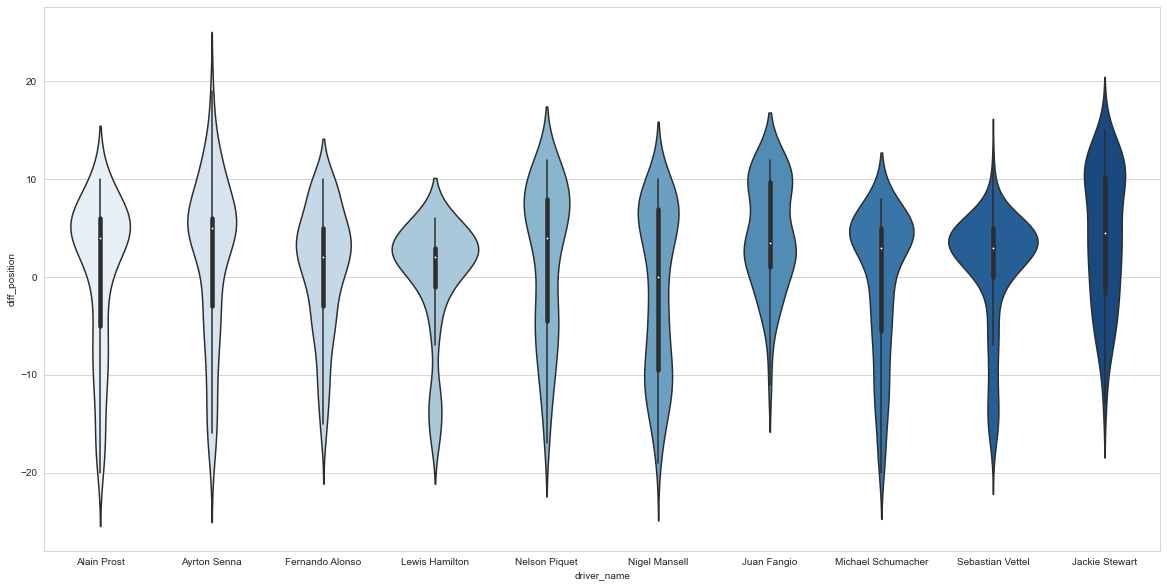

In [32]:
# постороим диаграмму violinplot
fig, ax = plt.subplots(figsize=(20,10))
sns.set_style("whitegrid")
sns.violinplot(data=data_19, x="driver_name", y="diff_position",palette='Blues')
plt.show()

### Анализ визуализации:

Основная часть позиций на финише у всех гонщиков выше командной на 4-10 позиций.

При этом:

•	у Ayrton Senna - лучшее медианное значение т.е. он финишировал выше на 5 позиций

•	Juan Fangio – практически всегда финишировал выше чем команда  - все финишные места по 25-75 квартилям выше минимум на 1 позицию, но при этом  медиана хуже, чем у Ayrton Senna

•	Jackie Stewart - также показывает один из лучших результатов по медиане и 25-75 квартилям

•	у Nigel Mansell, Kimi Raikkonen, Lewis Hamilton – больше всех финишей, хуже чем среднее значение по команде.

Особенно выделяются:

•	Lewis Hamilton – основная часть результатов отличная и приближается к лучшим в это исследовании, однако имеются финиши на в рамках 10-20 позиций хуже, чем по команде, учитывая тот факт, что он выступал только в двух командах (McLaren, Mercedes), являющихся топ-командами - это заставляет задуматься о стабильности результатов данного гонщика.

•	Nigel Mansell - также довольно много результатов на 10-20 позиций хуже, чем по команде, а также медиана, равная 0, позволяет сделать вывод о том, что это обычный, среднестатистический гонщик (между прочим Чемпион мира 1992 года) просто оказавшийся в нужном месте в нужное время


### Проверка гипотезы

В ходе исследования мы сформировали следующие гипотезы:

• Нулевая гипотеза H₀: Средняя позиция гонщика на финише равна средней позиции команд(как правило их несколько за карьеру) в которых он был гонщиком

• Альтернативная гипотеза H₁: Средняя позиция гонщика на финише не равна средней позиции команд, в которых он был гонщиком

Так как мы сравниваем два средних из двух выборок, из библиотеки scipy подбираем метод ttest_ind(), если обе выборки имеют нормальное распределение.
Если хоть одна из двух выборок нормального распределения не имеет, используем метод Манна-Уитни. 

Чтобы понять нормальное распределение имеют выборки или нет, используем для обеих критерий Шапиро.

In [34]:
# используем критерий Шапиро
alpha = 0.01

list_1 =['Ayrton Senna', 'Michael Schumacher', 'Alain Prost', 'Nelson Piquet','Nigel Mansell','Juan Fangio', 'Fernando Alonso', 'Lewis Hamilton', 'Jackie Stewart', 'Sebastian Vettel']  
for i in list_1:
    user_score_for_1 = data_19[data_19['driver_name'] == i]['driver_position'].dropna()
    results = st.shapiro(user_score_for_1)
#     print(results, i)
    if (results[1] < alpha):
        print('Распределение не нормальное', i)
    else:
        print("Распределение нормальное", i)   


Распределение не нормальное Ayrton Senna
Распределение не нормальное Michael Schumacher
Распределение не нормальное Alain Prost
Распределение не нормальное Nelson Piquet
Распределение не нормальное Nigel Mansell
Распределение не нормальное Juan Fangio
Распределение не нормальное Fernando Alonso
Распределение не нормальное Lewis Hamilton
Распределение не нормальное Jackie Stewart
Распределение не нормальное Sebastian Vettel


Т.к. все распределения не нормальны для проверки гипотезы возьмем критерий Манна-Уитни.

In [35]:
list_1 =['Ayrton Senna', 'Michael Schumacher', 'Alain Prost', 'Nelson Piquet','Nigel Mansell','Juan Fangio', 'Fernando Alonso', 'Lewis Hamilton', 'Jackie Stewart', 'Sebastian Vettel']  
for i in list_1:
    user_score_for_1 = data_19[data_19['driver_name'] == i]['driver_position'].dropna()
    user_score_for_2 = data_19['constr_med_position'].dropna()
    results = st.mannwhitneyu(user_score_for_1, user_score_for_2)
    if (results.pvalue < alpha):
        print("Отвергаем нулевую гипотезу о том", i, results.pvalue)
    else:
        print("Не получилось отвергнуть нулевую гипотезу", i, results.pvalue)

Отвергаем нулевую гипотезу о том Ayrton Senna 7.422683471881532e-08
Отвергаем нулевую гипотезу о том Michael Schumacher 8.825988662840617e-24
Отвергаем нулевую гипотезу о том Alain Prost 3.986691074608201e-15
Не получилось отвергнуть нулевую гипотезу Nelson Piquet 0.14647060887392727
Отвергаем нулевую гипотезу о том Nigel Mansell 0.009498653959681093
Отвергаем нулевую гипотезу о том Juan Fangio 8.914700381602509e-12
Отвергаем нулевую гипотезу о том Fernando Alonso 3.250245098695479e-09
Отвергаем нулевую гипотезу о том Lewis Hamilton 7.433566472974427e-42
Отвергаем нулевую гипотезу о том Jackie Stewart 5.359107478417987e-05
Отвергаем нулевую гипотезу о том Sebastian Vettel 2.0258882814209603e-33


In [29]:
# используем критерий Шапиро
alpha = 0.01

list_1 =['Ayrton Senna', 'Michael Schumacher', 'Alain Prost', 'Nelson Piquet','Nigel Mansell','Juan Fangio', 'Kimi Raikkonen', 'Fernando Alonso', 'Lewis Hamilton', 'Jackie Stewart']  
for i in list_1:
    user_score_for_1 = data_19[data_19['driver_name'] == i]['driver_position'].dropna()
    results = st.shapiro(user_score_for_1)
#     print(results, i)
    if (results[1] < alpha):
        print('Распределение не нормальное', i)
    else:
        print("Распределение нормальное", i)   


Распределение не нормальное Ayrton Senna
Распределение не нормальное Michael Schumacher
Распределение не нормальное Alain Prost
Распределение не нормальное Nelson Piquet
Распределение не нормальное Nigel Mansell
Распределение не нормальное Juan Fangio
Распределение не нормальное Kimi Raikkonen
Распределение не нормальное Fernando Alonso
Распределение не нормальное Lewis Hamilton
Распределение не нормальное Jackie Stewart


In [30]:
list_1 =['Ayrton Senna', 'Michael Schumacher', 'Alain Prost', 'Nelson Piquet','Nigel Mansell','Juan Fangio', 'Kimi Raikkonen', 'Fernando Alonso', 'Lewis Hamilton', 'Jackie Stewart', 'Sebastian Vettel']  
for i in list_1:
    user_score_for_1 = data_19[data_19['driver_name'] == i]['driver_position'].dropna()
    user_score_for_2 = data_19['constr_med_position'].dropna()
    results = st.mannwhitneyu(user_score_for_1, user_score_for_2)
    if (results.pvalue < alpha):
        print("Отвергаем нулевую гипотезу",results.pvalue, i)
    else:
        print("Не получилось отвергнуть нулевую гипотезу.",results.pvalue, i)

Отвергаем нулевую гипотезу 7.886471512655217e-08 Ayrton Senna
Отвергаем нулевую гипотезу 8.321798991439642e-24 Michael Schumacher
Отвергаем нулевую гипотезу 3.498568804888438e-15 Alain Prost
Не получилось отвергнуть нулевую гипотезу. 0.16406615087369136 Nelson Piquet
Отвергаем нулевую гипотезу 0.007600365160029127 Nigel Mansell
Отвергаем нулевую гипотезу 9.7624147609751e-12 Juan Fangio
Отвергаем нулевую гипотезу 9.027181495922137e-12 Kimi Raikkonen
Отвергаем нулевую гипотезу 4.745638378622312e-09 Fernando Alonso
Отвергаем нулевую гипотезу 2.212313445309416e-42 Lewis Hamilton
Отвергаем нулевую гипотезу 6.187612849530729e-05 Jackie Stewart
Отвергаем нулевую гипотезу 6.085243630145119e-34 Sebastian Vettel


### Выводы:

Основная часть позиций на финише у всех гонщиков выше командной на 4-10 позиций.

При этом:

•	у Ayrton Senna - лучшее медианное значение т.е. он финишировал выше на 5 позиций

•	Juan Fangio – практически всегда финишировал выше чем команда  - все финишные места по 25-75 квартилям выше минимум на 1 позицию, но при этом  медиана хуже, чем у Ayrton Senna

•	Jackie Stewart - также показывает один из лучших результатов по медиане и 25-75 квартилям

•	у Nigel Mansell, Kimi Raikkonen, Lewis Hamilton – больше всех финишей, хуже чем среднее значение по команде.

Особенно выделяются:

•	Lewis Hamilton – основная часть результатов отличная и приближается к лучшим в это исследовании, однако имеются финиши на в рамках 10-20 позиций хуже, чем по команде, учитывая тот факт, что он выступал только в двух командах (McLaren, Mercedes), являющихся топ-командами - это заставляет задуматься о стабильности результатов данного гонщика.

•	Nigel Mansell - также довольно много результатов на 10-20 позиций хуже, чем по команде, а также медиана, равная 0, позволяет сделать вывод о том, что это обычный, среднестатистический гонщик (между прочим Чемпион мира 1992 года) просто оказавшийся в нужном месте в нужное время
